In [37]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn

In [30]:
weather = pd.read_csv("3588306.csv", index_col="DATE")

In [31]:
del weather["HLY-PRES-NORMAL"]
weather

,STATION,NAME,HLY-TEMP-NORMAL,HLY-WIND-1STDIR
DATE,,,,
01-01T01:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",39.2,5
01-01T02:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",39.0,5
01-01T03:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",38.9,5
01-01T04:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",38.8,5
01-01T05:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",38.7,5
...,...,...,...,...
12-31T19:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",40.7,5
12-31T20:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",40.5,5
12-31T21:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",40.2,5


In [13]:
weather.apply(pd.isnull).sum()

STATION            0
NAME               0
HLY-TEMP-NORMAL    0
HLY-WIND-1STDIR    0
dtype: int64

In [16]:
weather.apply(lambda x: (x==9999).sum())

STATION            0
NAME               0
HLY-TEMP-NORMAL    0
HLY-WIND-1STDIR    0
dtype: int64

<Axes: xlabel='DATE'>

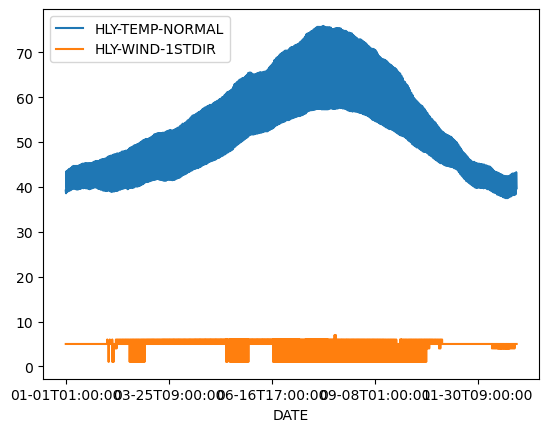

In [20]:
weather[["HLY-TEMP-NORMAL", "HLY-WIND-1STDIR"]].plot()

In [32]:
weather["target"] = weather.shift(-1)["HLY-TEMP-NORMAL"]

In [26]:
weather

,STATION,NAME,HLY-TEMP-NORMAL,HLY-WIND-1STDIR,target
DATE,,,,,
01-01T01:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",39.2,5,39.0
01-01T02:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",39.0,5,38.9
01-01T03:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",38.9,5,38.8
01-01T04:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",38.8,5,38.7
01-01T05:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",38.7,5,38.7
...,...,...,...,...,...
12-31T19:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",40.7,5,40.5
12-31T20:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",40.5,5,40.2
12-31T21:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",40.2,5,40.0


In [33]:
weather = weather.iloc[:-1,:].copy()

In [35]:
weather

,STATION,NAME,HLY-TEMP-NORMAL,HLY-WIND-1STDIR,target
DATE,,,,,
01-01T01:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",39.2,5,39.0
01-01T02:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",39.0,5,38.9
01-01T03:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",38.9,5,38.8
01-01T04:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",38.8,5,38.7
01-01T05:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",38.7,5,38.7
...,...,...,...,...,...
12-31T18:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",41.0,5,40.7
12-31T19:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",40.7,5,40.5
12-31T20:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",40.5,5,40.2


In [41]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=.1)

In [53]:
predictors = ["HLY-TEMP-NORMAL", "HLY-WIND-1STDIR"]

In [54]:
train = weather.loc[:"12-15T23:00:00"]
test = weather.loc["12-16T00:00:00":]

In [55]:
reg.fit(train[predictors], train["target"])

Ridge(alpha=0.1)

In [57]:
predictions = reg.predict(test[predictors])

f